# Imports

In [981]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
import seaborn as sns
sns.set_style('whitegrid')

# Convenience Functions

In [1621]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

# Read in Data

### VEH1153: Vehicles registered for the first time by body type and fuel type

In [1622]:
drop_cols_veh1153 = [
    'Units',
]

veh1153 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1153.ods", 
        engine="odf", 
        sheet_name='VEH1153a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Date Interval [note 4]': 'Date Interval',
            'Date [note 4]': 'Date',
            'Other vehicles [note 3]': 'Other vehicles',
            'Gas [note 5]': 'Gas',
            'Other fuel types [note 6]': 'Other fuel types',
            'Plug-in [note 7]': 'Plug-in',
            'Zero emission [note 8]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1153, axis=1)
)

# Convert units from Thousands to real counts
veh1153.iloc[:, 4:] = veh1153.iloc[:, 4:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1153['ICE'] = veh1153['Total'] - veh1153['Plug-in'] - veh1153['Fuel cell electric']

# Remove bracketed text from Dates
veh1153['Date'] = veh1153['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1153.head()

,Geography,Date Interval,Date,BodyType,Petrol,Diesel,Hybrid electric (petrol),Hybrid electric (diesel),Plug-in hybrid electric (petrol),Plug-in hybrid electric (diesel),Battery electric,Range extended electric,Fuel cell electric,Gas,Other fuel types,Total,Plug-in,Zero emission,ICE
374,England,Annual,2001,Cars,1874649.0,405214.0,604.0,3.0,0.0,0.0,81.0,0.0,0.0,1954.0,7.0,2282512.0,81.0,81.0,2282431.0
375,England,Annual,2002,Cars,1793879.0,563102.0,270.0,0.0,0.0,0.0,58.0,0.0,1.0,2311.0,3.0,2359624.0,58.0,59.0,2359565.0
376,England,Annual,2003,Cars,1679322.0,641920.0,351.0,0.0,0.0,0.0,39.0,0.0,3.0,3086.0,6.0,2324727.0,39.0,42.0,2324685.0
377,England,Annual,2004,Cars,1524998.0,749242.0,1442.0,0.0,0.0,0.0,90.0,0.0,2.0,1681.0,8.0,2277463.0,90.0,92.0,2277371.0
378,England,Annual,2005,Cars,1343752.0,794699.0,4997.0,3.0,0.0,0.0,223.0,0.0,4.0,482.0,13.0,2144173.0,223.0,227.0,2143946.0


### VEH1103: Licensed vehicles at the end of the quarter by body type and fuel type

In [1623]:
drop_cols_veh1103 = [
    'Units',
]

veh1103 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1103.ods", 
        engine="odf", 
        sheet_name='VEH1103a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Gas [note 4]': 'Gas',
            'Other fuel types [note 5]': 'Other fuel types',
            'Plug-in [note 6]': 'Plug-in',
            'Zero emission [note 7]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1103, axis=1)
)

# Convert units from Thousands to real counts
veh1103.iloc[:, 3:] = veh1103.iloc[:, 3:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1103['ICE'] = veh1103['Total'] - veh1103['Plug-in'] - veh1103['Fuel cell electric']

# Remove bracketed text from Dates
veh1103['Date'] = veh1103['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1103.head()

,Geography,Date,BodyType,Petrol,Diesel,Hybrid electric (petrol),Hybrid electric (diesel),Plug-in hybrid electric (petrol),Plug-in hybrid electric (diesel),Battery electric,Range extended electric,Fuel cell electric,Gas,Other fuel types,Total,Plug-in,Zero emission,ICE
72,England,1994 Q4,Cars,16694257.0,1313637.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,1543.0,192.0,18009710.0,81.0,81.0,18009629.0
73,England,1995 Q4,Cars,16635739.0,1573698.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,2518.0,121.0,18212137.0,61.0,61.0,18212076.0
74,England,1996 Q4,Cars,17149424.0,1811387.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,3587.0,107.0,18964584.0,79.0,79.0,18964505.0
75,England,1997 Q4,Cars,17505628.0,2031080.0,0.0,0.0,0.0,0.0,101.0,0.0,0.0,5577.0,104.0,19542490.0,101.0,101.0,19542389.0
76,England,1998 Q4,Cars,17744318.0,2247998.0,0.0,0.0,0.0,0.0,140.0,0.0,0.0,8650.0,100.0,20001206.0,140.0,140.0,20001066.0


### LSOA Lookup Data

In [1624]:
LAD = 'Bath and North East Somerset' # Target Local Authority District

In [1625]:
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London,NaN,1
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London,NaN,2
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London,NaN,3
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London,NaN,4
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham,NaN,5


### Historical Total Vehicle Registration Data for LSOAs

In [1626]:
v_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' and Keepership == 'Private' and LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority (BNES)
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
v_lsoa = v_lsoa[~v_lsoa.index.duplicated(keep='first')]

v_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,361.0,353.0,357.0,352.0,369.0,390.0,382.0,380.0,371.0,372.0,...,390.0,397.0,391.0,393.0,384.0,389.0,406.0,378.0,384.0,386.0
E01014371,502.0,512.0,507.0,524.0,517.0,524.0,524.0,530.0,523.0,512.0,...,537.0,552.0,546.0,557.0,552.0,540.0,538.0,549.0,547.0,557.0
E01014372,495.0,507.0,506.0,509.0,513.0,508.0,506.0,508.0,500.0,479.0,...,548.0,553.0,556.0,552.0,571.0,561.0,588.0,604.0,595.0,591.0
E01014373,753.0,754.0,770.0,768.0,775.0,762.0,773.0,740.0,749.0,759.0,...,680.0,674.0,690.0,688.0,695.0,692.0,684.0,696.0,692.0,703.0
E01014374,752.0,762.0,759.0,756.0,746.0,750.0,741.0,739.0,727.0,718.0,...,632.0,627.0,632.0,637.0,634.0,633.0,637.0,628.0,627.0,641.0


### Historical Electric Vehicle Registration Data for LSOAs by Propulsion Type

In [1627]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

,Fuel,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,Battery electric,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014370,Plug-in hybrid electric (petrol),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014370,Total,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,Battery electric,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,Plug-in hybrid electric (diesel),NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This now needs to be disaggregated by propulsion type.

#### Historical BEV Registration Data for LSOAs

In [1628]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,7.0,5.0,5.0,5.0,NaN,5.0,5.0,5.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,10.0,12.0,11.0,11.0,11.0,9.0,7.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,20.0,17.0,18.0,18.0,15.0,15.0,10.0,8.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Historical PHEV Registration Data for LSOAs

In [1629]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,5.0,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,12.0,11.0,10.0,9.0,8.0,7.0,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Historical EV Registration Data for LSOAs

In [1630]:
total_ev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Total' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
total_ev_lsoa = total_ev_lsoa[~total_ev_lsoa.index.duplicated(keep='first')]

total_ev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,10.0,11.0,10.0,10.0,7.0,7.0,7.0,6.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,12.0,9.0,9.0,8.0,8.0,11.0,10.0,9.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,14.0,15.0,15.0,15.0,15.0,13.0,11.0,11.0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,34.0,30.0,30.0,29.0,24.0,23.0,16.0,13.0,10.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Historical ICE Registration Data for LSOAs

The difference between the total vehicle and EV registration is assumed to be the ICE registration.

In [1631]:
ice_lsoa = v_lsoa.subtract(total_ev_lsoa)
ice_lsoa = ice_lsoa[ice_lsoa.columns[::-1]]
ice_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,348.0,341.0,347.0,341.0,358.0,382.0,376.0,NaN,NaN,NaN,...,390.0,397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014371,492.0,501.0,497.0,514.0,510.0,517.0,517.0,524.0,NaN,NaN,...,537.0,552.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014372,483.0,498.0,497.0,501.0,505.0,497.0,496.0,499.0,491.0,472.0,...,548.0,553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014373,739.0,739.0,755.0,753.0,760.0,749.0,762.0,729.0,739.0,750.0,...,680.0,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014374,718.0,732.0,729.0,727.0,722.0,727.0,725.0,726.0,717.0,709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Interpolate Missing Registration Data

Historical registration data is not reported if the number of registered vehicles in an LSOA is: $0 < n < 5$.

Therefore, missing registration data is interpolated in order to better capture trends in EV registration.

In [1632]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)

    interpolated_df = interpolated_df.fillna(0)
    
    return interpolated_df

In [1633]:
bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_ev_lsoa_i = interpolate_registration_data(total_ev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_lsoa_i = interpolate_registration_data(v_lsoa.T.iloc[::-1], sample_rate=sample_rate)

# Doing this afterwards with interpolated data reduces the number of NaNs
ice_lsoa_i = total_lsoa_i.subtract(total_ev_lsoa_i)
ice_lsoa_i.tail()

LSOA11CD,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01014478,E01014479,E01014480,E01014481,E01014482,E01014483,E01014484,E01033078,E01033079,E01033080
2021 Q4,358.0,510.0,505.0,760.0,722.0,827.0,979.0,806.0,1320.0,722.0,...,469.0,656.0,549.0,382.0,598.0,441.0,383.0,1015.0,716.0,582.0
2022 Q1,341.0,514.0,501.0,753.0,727.0,820.0,992.0,806.0,1324.0,723.0,...,459.0,654.0,546.0,377.0,604.0,437.0,377.0,999.0,708.0,592.0
2022 Q2,347.0,497.0,497.0,755.0,729.0,814.0,986.0,802.0,1310.0,727.0,...,451.0,651.0,544.0,369.0,600.0,434.0,390.0,983.0,703.0,585.0
2022 Q3,341.0,501.0,498.0,739.0,732.0,815.0,965.0,788.0,1310.0,731.0,...,452.0,652.0,545.0,382.0,600.0,431.0,397.0,974.0,684.0,570.0
2022 Q4,348.0,492.0,483.0,739.0,718.0,784.0,968.0,788.0,1308.0,720.0,...,455.0,651.0,535.0,387.0,596.0,424.0,396.0,968.0,692.0,582.0


# "Global" Variables

In [1663]:
RANDOM_SEED = 42

sample_rate = 4 # Quarterly
region = 'England'

# Inital estimates for BEV and PHEV lifetimes
bev_lifetime = 12 # Years
phev_lifetime = 15 # Years

horizon = 2050 # How far into the future we're looking

ice_ban = 2030 # The year in which the sale of new ICE vehicles is banned in the UK
phev_ban = 2035 # The year in which the sale of new Hybrid vehicles is banned in the UK

# Approximate Vehicle Retirement Rates

I am assuming that the retirement rate of ICE vehicles is equal to the quarterly number of retired ICEs divided by the total number of registered ICEs. This represents the proportion of the ICE stock that retire each quarter. The inverse of this would give an estimate for the average lifespan of an ICE. This works out at around 18 years.

I should probably calculate retirement rates for each LSOA. For instance, one LSOA might have a high throughput of vehicles, whilst another might retain vehicles for longer.

In [1664]:
# Number of ICE vehicles currently registered in the "region"
n_ice = veh1103.loc[(veh1103['Geography'] == region), 'ICE'].iloc[-1]
n_ice

26459296.0

In [1665]:
# ICE Retirements
ice_retirements = (veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
                       veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()).mean() # Per Quarter
ice_retirement_rate = ice_retirements/n_ice
ice_retirement_rate

0.013699838888672334

In [1666]:
bev_retirement_rate = 1/(4*bev_lifetime)
bev_retirement_rate

0.020833333333333332

In [1667]:
phev_retirement_rate = 1/(4*phev_lifetime)
phev_retirement_rate

0.016666666666666666

# Estimate New Vehicle Registrations in each LSOA

The rolling averaging of the new vehicle approximations helps to eliminate any "high-frequency" noise in the data and makes the interpolation of sales shares more reliable.

In [1668]:
rolling_average_window = 8 # Quarters

new_bev_lsoa = bev_lsoa_i.diff().add(bev_lsoa_i*bev_retirement_rate) # Approximate new BEV registrations per quarter
new_bev_lsoa[new_bev_lsoa < 0] = 0
smoothed_new_bev_lsoa = new_bev_lsoa.rolling(rolling_average_window).mean() # Calculate rolling average

new_phev_lsoa = phev_lsoa_i.diff().add(phev_lsoa_i*phev_retirement_rate) # Approximate new PHEV registrations per quarter
new_phev_lsoa[new_phev_lsoa < 0] = 0
smoothed_new_phev_lsoa = new_phev_lsoa.rolling(rolling_average_window).mean()

new_ice_lsoa = ice_lsoa_i.diff().add(ice_lsoa_i*ice_retirement_rate) # Approximate new ICE registrations per quarter
new_ice_lsoa[new_ice_lsoa < 0] = 0
smoothed_new_ice_lsoa = new_ice_lsoa.rolling(rolling_average_window).mean()

smoothed_new_vehicles_lsoa = sum([smoothed_new_ice_lsoa, smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_ev_lsoa = sum([smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])

# Forecasting the Sales Share for Each Propulsion Type

Given ICE and PHEV New Sale Bans

In [1669]:
def calculate_sales_share(target, parent, ban, value_at_ban):
    sales_share = target.divide(parent) # Target = Vehicle time, parent = Parent vehicle type

    # The following sets any cell that contains NaN or 0 to 0.5 share as the last entry. 
    # Between the current date and the legislative ban there is still a chance that a region could see a rise in vehicle ownership
    # Despite there being no registrations of those vehicle types in the past.

    sales_share.iloc[-1] = sales_share.iloc[-1].fillna(0.5)
    sales_share.iloc[-1][sales_share.iloc[-1] == 0] = 0.5

    sales_share = sales_share.fillna(0) # 0.0/0.0 = NaN. Therefore, I replace the NaNs with 0 (Need to review this)
    
    dates = convert_dates_to_numeric(sales_share) # Historical Dates
    date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate) # Current and Future Dates

    sales_share['Date_numeric'] = dates
    sales_share = sales_share.set_index('Date_numeric')
    sales_share = sales_share.reindex(date_range)

    # Linear Interpolation
    sales_share.loc[ban, :] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    sales_share = sales_share.interpolate()
    return sales_share

In [1670]:
# ev_sales_share_lsoa = calculate_sales_share(smoothed_new_ev_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 1)
ice_sales_share_lsoa = calculate_sales_share(smoothed_new_ice_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 0)
# bev_sales_share_lsoa = calculate_sales_share(smoothed_new_bev_lsoa, smoothed_new_ev_lsoa, phev_ban, 1)
phev_sales_share_lsoa = calculate_sales_share(smoothed_new_phev_lsoa, smoothed_new_ev_lsoa, phev_ban, 0)

<Axes: title={'center': 'Share of new EVs that are PHEVs in each LSOA'}, xlabel='Date_numeric'>

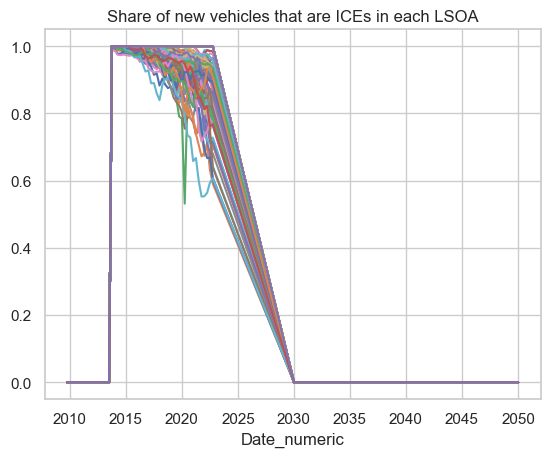

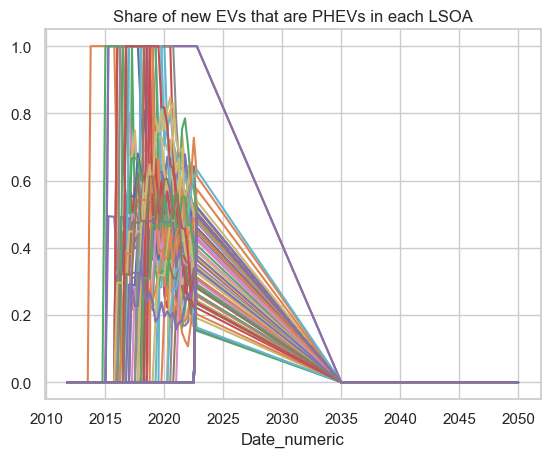

In [1671]:
ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA')
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA')

# Incorporating Anticipatory behaviour

Have one linear function that trends towards 0 or 1 share of vehicle propulsion type.

Multiply this by an anticipatory function that expontentially increases/decreases up until the relevant ban.

The shape of this curve dictates the extent of anticipatory behaviour prior to a ban.

This should only be used for the legacy vehicles with the disrupter vehicles' sales share being inferred.

As the linear function ends at 0 share on the date of the ban, the exponential function is constrained at 0 at that point. This should look pretty cool!

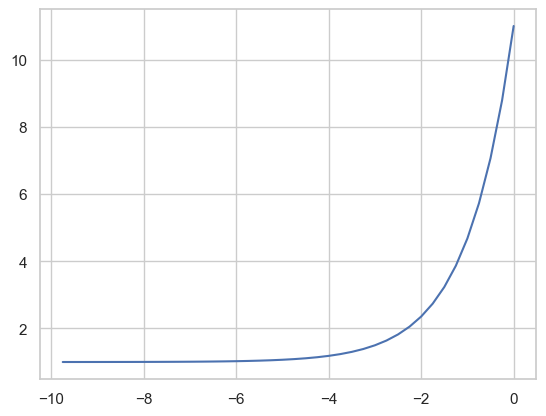

In [1672]:
anticipatory_period = 10

x = np.linspace(-(anticipatory_period - (1/sample_rate)), 0, 40) # 10 years (40 quarters)

# ICE Anticipatory Parameters
a = 10
b = 1

y_ice = a * np.exp(b * x) + 1

# PHEV Anticipatory Parameters
c = 10
d = 1

y_phev = c * np.exp(d * x) + 1

plt.plot(x, y_ice)

<Axes: title={'center': 'Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

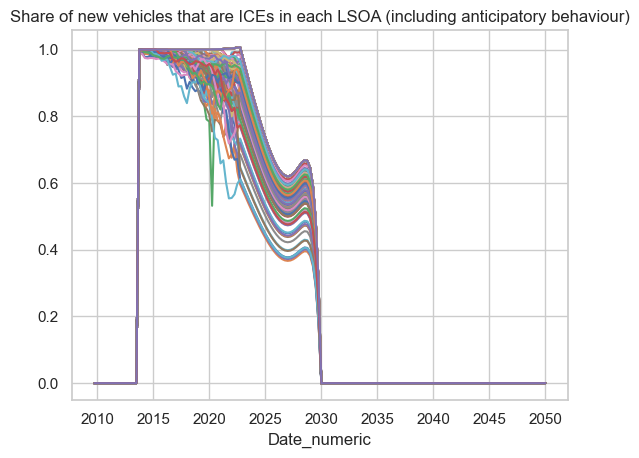

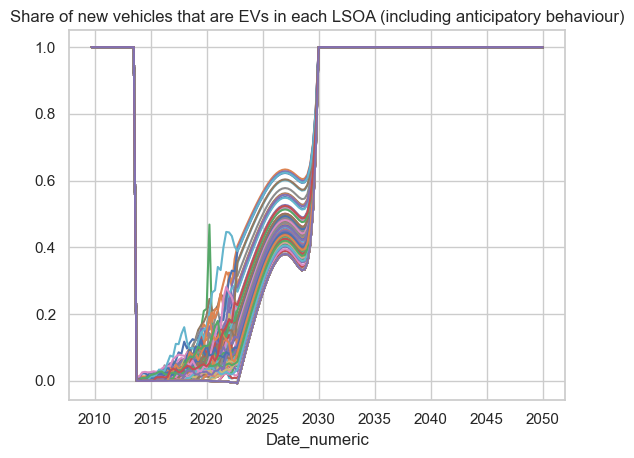

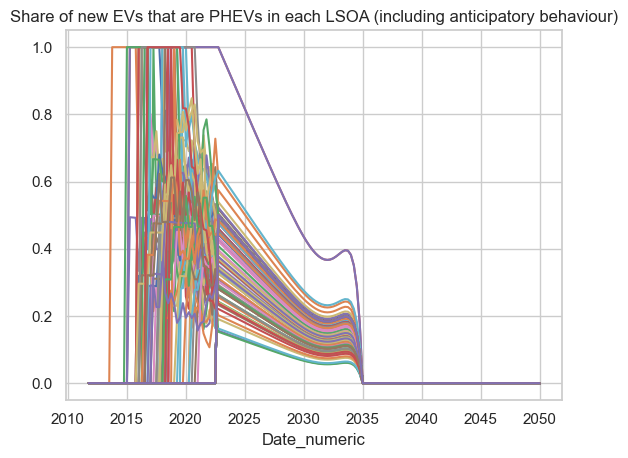

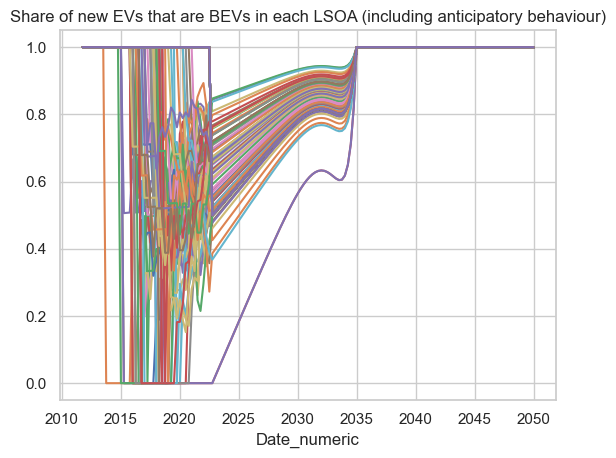

In [1673]:
ice_sales_share_lsoa.loc[ice_ban - 9.75 : ice_ban] = ice_sales_share_lsoa.loc[ice_ban - 9.75 : ice_ban].multiply(y_ice, axis=0)
ev_sales_share_lsoa = 1 - ice_sales_share_lsoa

phev_sales_share_lsoa[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban] = phev_sales_share_lsoa.loc[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban].multiply(y_phev, axis=0)
bev_sales_share_lsoa = 1 - phev_sales_share_lsoa

ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA (including anticipatory behaviour)')
ev_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are EVs in each LSOA (including anticipatory behaviour)')
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA (including anticipatory behaviour)')
bev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)')

# Probabilistic Modelling of Future Vehicle Adoption

Trying to account for the uncertainty in overal new vehicle registrations.

In [1674]:
# Bayesian Stuff
import pymc as pm
import arviz as az

### New Vehicle Registrations

<Axes: >

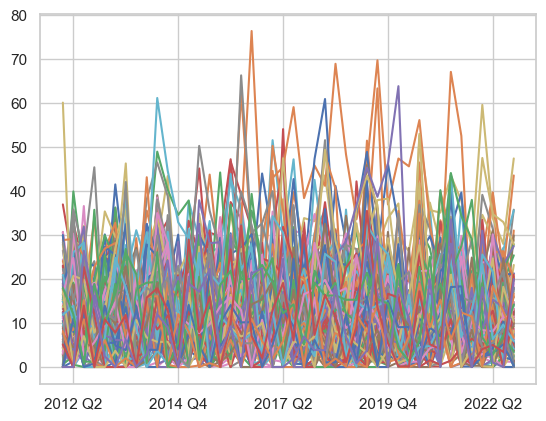

In [1675]:
new_vehicles_lsoa = sum([new_ice_lsoa, new_bev_lsoa, new_phev_lsoa])
new_vehicles_lsoa.plot(legend=False)

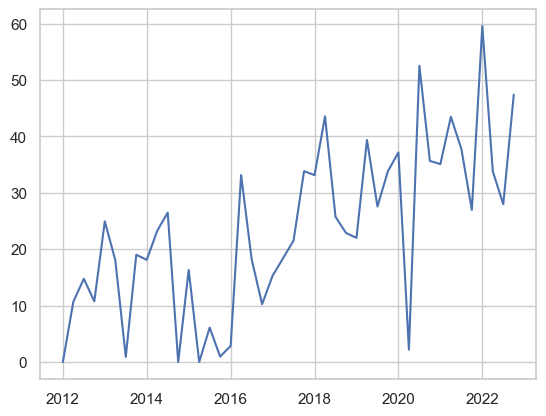

In [1696]:
target_lsoa = 'E01014399'

target_lsoa_data = new_vehicles_lsoa[target_lsoa].dropna().to_numpy()
plt.plot(convert_dates_to_numeric(new_vehicles_lsoa.dropna()), target_lsoa_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

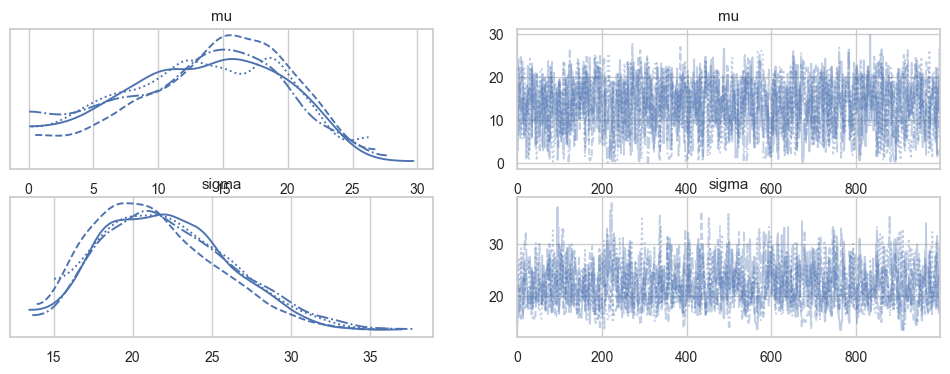

In [1700]:
with pm.Model() as new_vehicle_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=np.max(target_lsoa_data))  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=50)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=target_lsoa_data)

with new_vehicle_model:
    trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(trace)

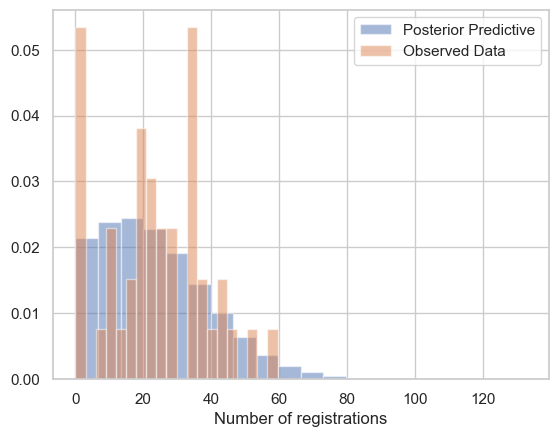

In [1701]:
# Generate random samples from the posterior predictive distribution
with new_vehicle_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Plot the posterior predictive distribution
plt.hist(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(target_lsoa_data, bins=20, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Number of registrations')
plt.legend()
plt.show()

In [1702]:
# Creates a range of numeric dates between t0 and t1 at a given sample rate
forecast_dates = calculate_date_range(t0=calculate_t_present(bev_lsoa_i), t1=horizon, sample_rate=4)

n_sim = 1000 # Number of simulated forecasting trajectories
new_vehicles_random = np.random.choice(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), size=(n_sim, len(forecast_dates)))

new_ev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_ice_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_bev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_phev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_lsoa_forecast[i+1] = ev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
    new_ice_lsoa_forecast[i+1] = ice_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
    new_bev_lsoa_forecast[i+1] = bev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')
    new_phev_lsoa_forecast[i+1] = phev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')

### Plotting Percentile Ranges

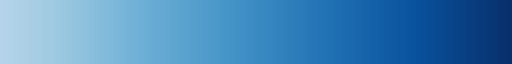

In [1681]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)
new_cmap

In [1682]:
NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [1683]:
def plot_probabilistic_vehicle_forecasts(df, historical_df, vehicle_type):
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.01, axis=1).values, 
        y2=df.quantile(0.99, axis=1).values, 
        color=colors[19],
        alpha=0.1,
        label='1st to 99th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.05, axis=1).values, 
        y2=df.quantile(0.95, axis=1).values, 
        color=colors[19],
        alpha=0.2,
        label='5th to 95th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.1, axis=1).values, 
        y2=df.quantile(0.9, axis=1).values, 
        color=colors[19],
        alpha=0.4,
        label='10th to 90th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.25, axis=1).values, 
        y2=df.quantile(0.75, axis=1).values, 
        color=colors[19],
        alpha=0.6,
        label='Interquartile Range'
    )

    ax.plot(
        df.index.values, 
        df.quantile(0.5, axis=1).values, 
        linewidth=2, 
        c='black', 
        label='Median'
    )

    ax.plot(
        convert_dates_to_numeric(historical_df.dropna()),
        historical_df[target_lsoa].dropna().values,
        linewidth=2,
        c='green',
        label='Historical Data'
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels, 
        # bbox_to_anchor=(1, 0.9), 
        title='Percentile', 
        title_fontsize=16, 
        fontsize=10
    )
    ax.set_title('Forecasted number of {}s for LSOA: {}'.format(vehicle_type, target_lsoa))
    ax.set_ylabel('Number of Registered Vehicles', fontsize=12)
    ax.set_xlabel('Time (Years)', fontsize=12)
    # ax.set_xlim(2022, horizon)
    plt.show()

### Account for uncertainty in vehicle retirement rate

#### *ICE*

In [1684]:
# Calculate the difference between the (English) ICE stock in sequential quarters using .diff()
# Subtract this from the number of new ICE registrations in the region (England) to estimate the number of retired ICEs in England each quarter
# Divide this by the number of total number of ICEs registered in each quarter to estimate an ICE retirement rate for England
# Convert this to a numpy array using to_numpy()

ice_retirement_rates_np = (
    veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
    veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()
).divide(veh1103.loc[(veh1103['Geography'] == region), ['Date', 'ICE']].set_index('Date')['ICE']).to_numpy()

# Replace any negative retirements rates with np.nan
ice_retirement_rates_np[ice_retirement_rates_np < 0] = np.nan

# Remove any np.nan values
ice_retirement_rates_np = ice_retirement_rates_np[~np.isnan(ice_retirement_rates_np)]
ice_retirement_rates_np

array([0.00583681, 0.01524846, 0.00431182, 0.007433  , 0.01570797,
       0.01675996, 0.01381743, 0.02064203, 0.01791176, 0.02146763,
       0.01143643, 0.01607625, 0.02079969, 0.01613976, 0.0134881 ,
       0.01848381, 0.01803162, 0.01687316, 0.01287251, 0.01510106,
       0.02007641, 0.01789411, 0.00921135, 0.01748127, 0.02019893,
       0.01585596, 0.00949129, 0.01557079, 0.02228001, 0.01834959,
       0.01220538, 0.01900227, 0.0195418 , 0.01495232, 0.01630631,
       0.02035339, 0.01704531, 0.02029675, 0.01396113, 0.01826822,
       0.02013184, 0.02017083, 0.0131868 , 0.01654303, 0.01768678,
       0.01756927, 0.01290866, 0.01534086, 0.01808429, 0.01260252,
       0.01851678, 0.00962102, 0.0163665 , 0.01604864, 0.00594068,
       0.01448902, 0.01383047, 0.01009146, 0.00819288, 0.01128529,
       0.01261462])

<Axes: >

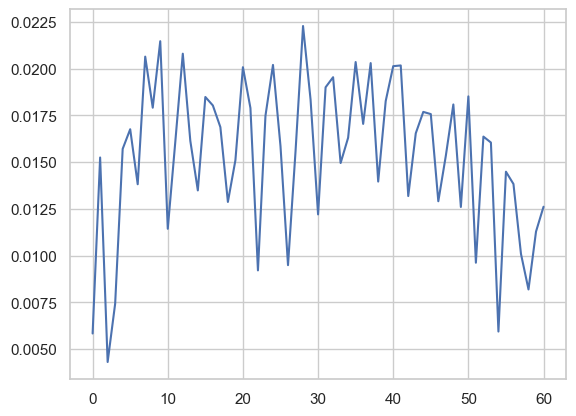

In [1685]:
sns.lineplot(ice_retirement_rates_np)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

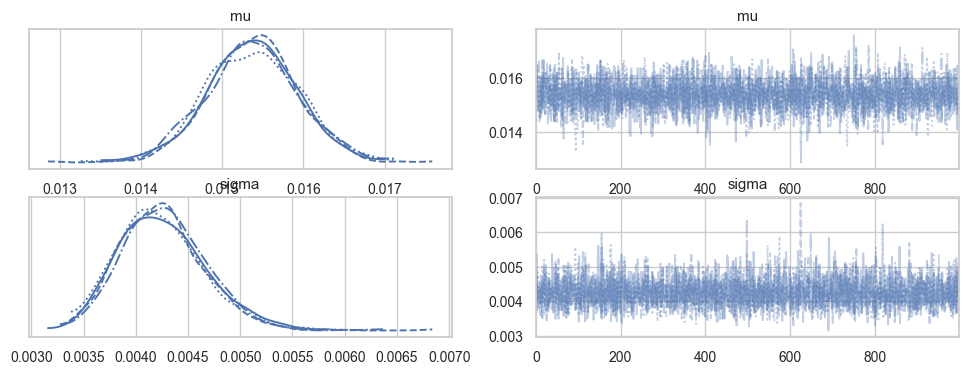

In [1686]:
with pm.Model() as retired_ice_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=0.5)  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=np.std(ice_retirement_rates_np) * 5)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('retirement_rates', mu=mu, sigma=sigma, lower=0, observed=ice_retirement_rates_np)

with retired_ice_model:
    retired_ice_trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(retired_ice_trace)

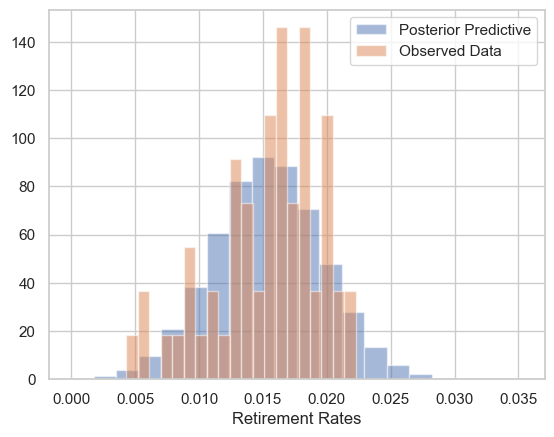

In [1687]:
# Generate random samples from the posterior predictive distribution
with retired_ice_model:
    retired_ice_posterior_predictive = pm.sample_posterior_predictive(retired_ice_trace)

# Plot the posterior predictive distribution
plt.hist(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(ice_retirement_rates_np, bins=20, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Retirement Rates')
plt.legend()
plt.show()

#### *BEV*

Due to the fact that BEVs and PHEVs are relatively new to the vehicle market, using historical data is not a reliable way of estimating their retirement rate.

Sampling: [mu, sigma, vehicle_lifetime]


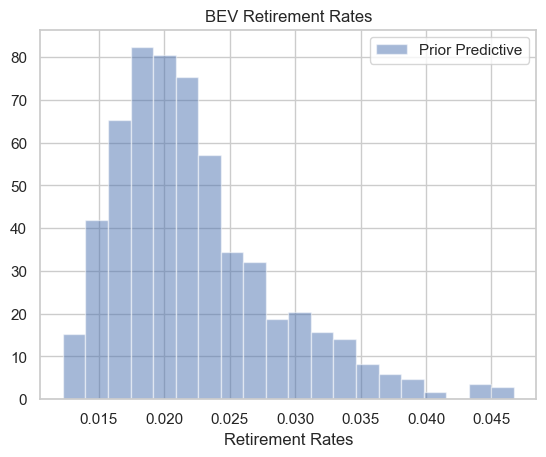

In [1688]:
with pm.Model() as retired_bev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=12, sigma=3)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))

with retired_bev_model:
    retired_bev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution
plt.hist(
    retired_bev_prior_predictive.prior.retirement_rate.values.flatten()[retired_bev_prior_predictive.prior.retirement_rate.values.flatten()<0.05], 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('BEV Retirement Rates')
plt.show()

#### *PHEV*

Sampling: [mu, sigma, vehicle_lifetime]


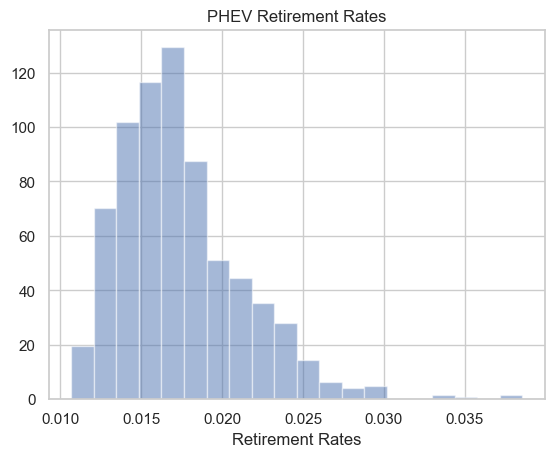

In [1689]:
with pm.Model() as retired_phev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=15, sigma=3)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))

with retired_phev_model:
    retired_phev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution
plt.hist(
    retired_phev_prior_predictive.prior.retirement_rate.values.flatten()[retired_phev_prior_predictive.prior.retirement_rate.values.flatten()<0.05], 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend
plt.title('PHEV Retirement Rates')
plt.show()

<Axes: >

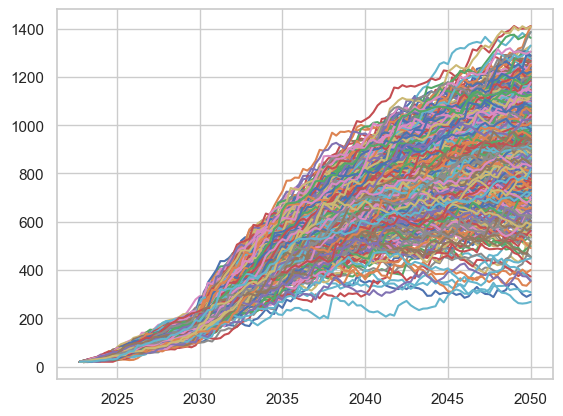

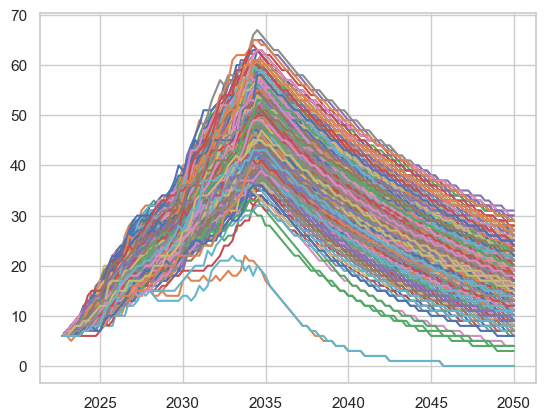

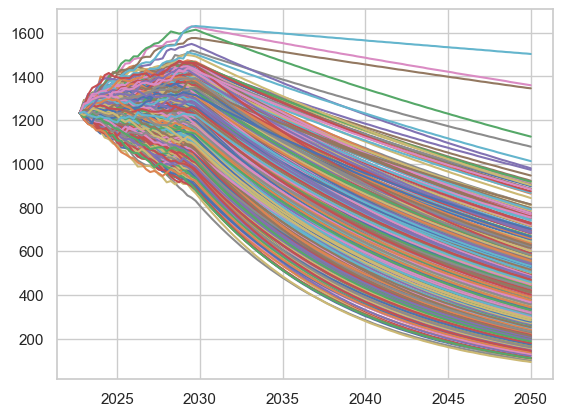

In [1706]:
# Create dataframes that contain a column for each simulation and a row for each forecasted date
bev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
phev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
ice_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)

# Populate forecast with inital starting registrations
bev_forecast_lsoa.iloc[0] = bev_lsoa_i[target_lsoa].iloc[-1]
phev_forecast_lsoa.iloc[0] = phev_lsoa_i[target_lsoa].iloc[-1]
ice_forecast_lsoa.iloc[0] = ice_lsoa_i[target_lsoa].iloc[-1]

# Randomly sample retirement rates from posterior/prior predictive distributions
ice_retirement_rates_random = np.random.choice(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), size=(n_sim))
bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

# Making the forecasts by adding new registrations and removing retired vehicles
for i in range(1, len(forecast_dates)):
    bev_forecast_lsoa.loc[forecast_dates[i]] = bev_forecast_lsoa.loc[forecast_dates[i-1]] + new_bev_lsoa_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast_lsoa.loc[forecast_dates[i-1]])
    phev_forecast_lsoa.loc[forecast_dates[i]] = phev_forecast_lsoa.loc[forecast_dates[i-1]] + new_phev_lsoa_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast_lsoa.loc[forecast_dates[i-1]])
    ice_forecast_lsoa.loc[forecast_dates[i]] = ice_forecast_lsoa.loc[forecast_dates[i-1]] + new_ice_lsoa_forecast.loc[forecast_dates[i]] - (ice_retirement_rates_random * ice_forecast_lsoa.loc[forecast_dates[i-1]])

bev_forecast_lsoa = round(bev_forecast_lsoa)
phev_forecast_lsoa = round(phev_forecast_lsoa)
ice_forecast_lsoa = round(ice_forecast_lsoa)

bev_forecast_lsoa.plot(legend=False)
phev_forecast_lsoa.plot(legend=False)
ice_forecast_lsoa.plot(legend=False)

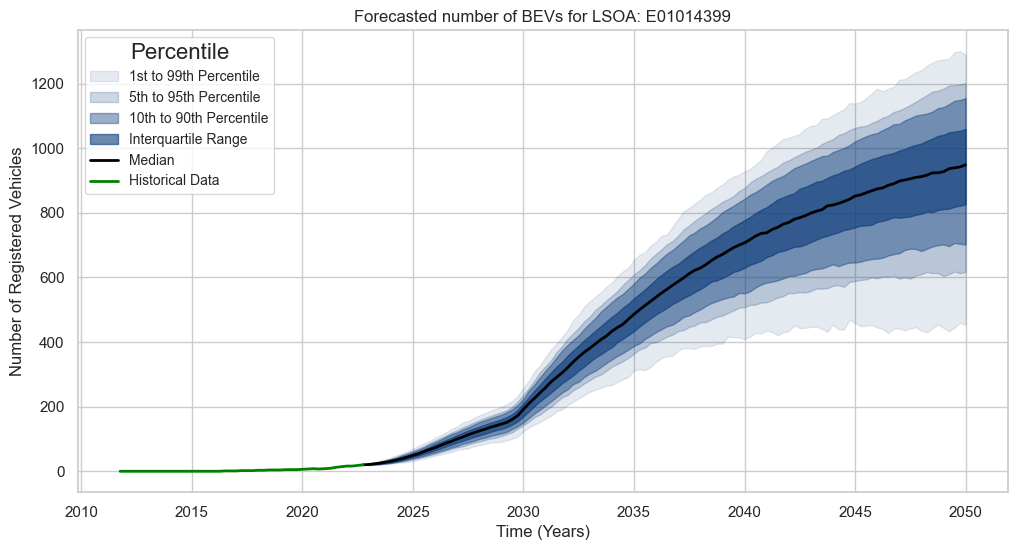

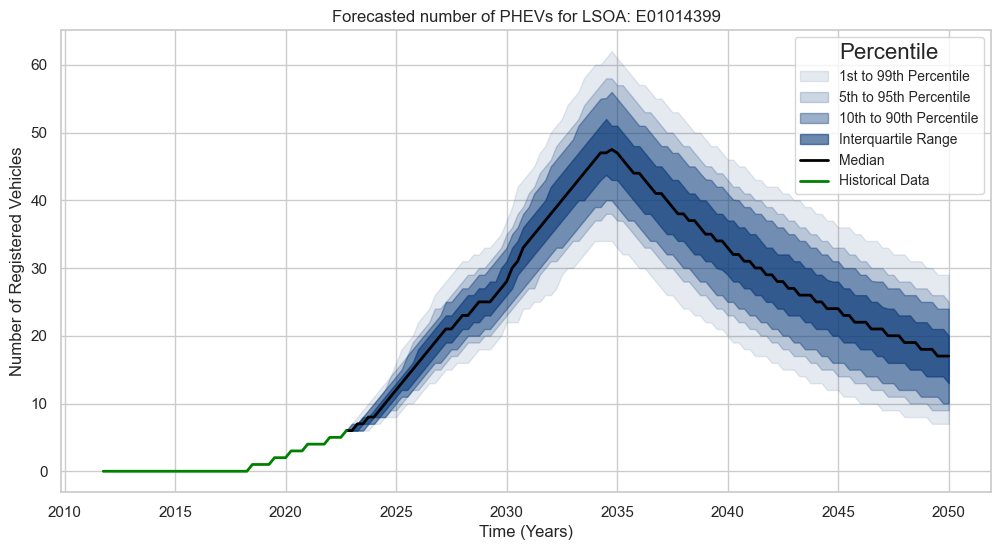

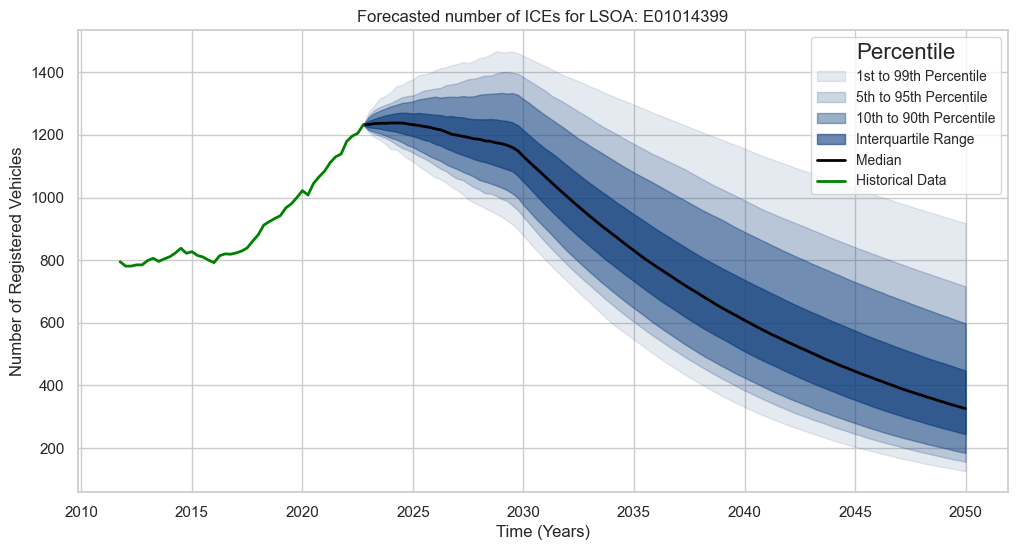

In [1707]:
plot_probabilistic_vehicle_forecasts(bev_forecast_lsoa, bev_lsoa_i, 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast_lsoa, phev_lsoa_i, 'PHEV')
plot_probabilistic_vehicle_forecasts(ice_forecast_lsoa, ice_lsoa_i, 'ICE')